# Depth Mapping from Normal Mapping with Averaged Integrals from Rotated Discrete Origin Functions


This algorithm estimates a 3d integral with the normal mapping. First the directional gradients of the normals in x- and y-direction are calculated. They are then used to calculate the integrated values by a cumulative sum (Riemann sum). This process is repeated with differently rotated versions of the gradient mapping to average the values and reduce errors as a cumulative sum alone is very prone for subsequent errors.


In [13]:
# @title Settings
NORMAL_MAP_PATH: str = "https://raw.githubusercontent.com/YertleTurtleGit/depth-from-normals/main/normal_mapping.png"  # @param {type: "string"}
NORMAL_MAP_IS_OPEN_GL: bool = True  # @param {type: "boolean"}
TARGET_ITERATION_COUNT: int = 1000
MAX_THREAD_COUNT: int = 4  # @param {type: "integer"}
DEPTH_MAP_PATH: str = "depth_mapping.png"  # @param {type: "string"}


## Imports


In [14]:
import numpy as np
import cv2 as cv
from scipy.integrate import cumulative_trapezoid
from skimage import io
from math import sin, cos, radians
from threading import Thread, Lock
from typing import List
from matplotlib import pyplot as plt


In [15]:
def estimate_depth_map(
    normal_map_uri: str,
    normal_map_is_open_gl: bool = True,
    target_iteration_count: int = 1000,
    max_thread_count: int = 1,
) -> np.ndarray:
    """Estimates a depth mapping from a given normal mapping.

    Parameters
    ----------
    normal_map_path : str
        The URI or simple file path to the normal mapping.
    normal_map_is_open_gl : bool, optional
        Set to `False` if the normal map is in DirectX format with flipped green/y channel, by default `True`.
    target_iteration_count : int, optional
        The target iteration count of the depth mapping defined how many iterations of integrations are performed, by default `1`.
    max_thread_count : int, optional
        The maximum number of threads used to calculate the depth mapping, by default `1`.

    Returns
    -------
    np.ndarray
        The depth mapping as image array.
    """

    normal_map = io.imread(normal_map_uri).astype(np.float64)
    width, height, _ = normal_map.shape
    normal_map = normal_map[:, :, :3]  # Remove alpha channel if present.
    normal_map = ((normal_map / 255) - 0.5) * 2  # Transform from [0, 255] to [-1, 1].
    if not normal_map_is_open_gl:
        normal_map[:, :, 1] *= -1  # Invert green/y channel if not OpenGL.

    gradient_map = np.empty((width, height, 2))
    gradient_map[:, :, 0] = -normal_map[:, :, 0] / normal_map[:, :, 2]
    gradient_map[:, :, 1] = normal_map[:, :, 1] / normal_map[:, :, 2]

    isotropic_integral = np.zeros((width, height))
    isotropic_integral_lock: Lock = Lock()

    def rotate(image: np.ndarray, angle: float, resize: bool = True) -> np.ndarray:
        from math import sqrt, ceil
        from cv2 import getRotationMatrix2D, warpAffine

        height, width = image.shape[:2]
        new_height: int = height
        new_width: int = width

        if resize:
            # TODO optimize new resolution
            image_diagonal_length: int = ceil(sqrt(height**2 + width**2))
            new_height = image_diagonal_length
            new_width = image_diagonal_length

        rotation_image = np.zeros((new_height, new_width))

        if resize:
            rotation_image[
                (new_height - height) // 2 : (new_height + height) // 2,
                (new_width - width) // 2 : (new_width + width) // 2,
            ] = image
        else:
            rotation_image = image

        rotation_matrix = getRotationMatrix2D(
            (new_width // 2, new_height // 2), angle, 1
        )
        return warpAffine(rotation_image, rotation_matrix, rotation_image.shape)

    def integrate_anisotropic(angles: List[float]):

        for angle in angles:

            anisotropic_gradient_map = rotate(
                gradient_map[:, :, 0] * cos(radians(angle))
                + gradient_map[:, :, 1] * sin(radians(angle)),
                angle,
            ).astype(np.float64)

            anisotropic_integral = rotate(
                cumulative_trapezoid(anisotropic_gradient_map),
                -angle,
            ).astype(np.float64)

            top_crop: int = (anisotropic_integral.shape[0] - height) // 2
            left_crop: int = (anisotropic_integral.shape[1] - width) // 2
            anisotropic_integral = anisotropic_integral[
                top_crop : top_crop + height,
                left_crop : left_crop + width,
            ]

            isotropic_integral_lock.acquire()
            nonlocal isotropic_integral
            isotropic_integral += anisotropic_integral
            isotropic_integral_lock.release()

    max_thread_count = max(max_thread_count, 1)
    anisotropic_integral_threads: List[Thread] = []
    angle_per_thread: float = 360 / max_thread_count
    iterations_per_thread: int = max(
        round(target_iteration_count / max_thread_count), 1
    )

    for thread_id in range(0, max_thread_count):
        angle_start_point: float = thread_id * angle_per_thread
        angle_stop_point: float = (thread_id + 1) * angle_per_thread

        angles = np.linspace(
            angle_start_point,
            angle_stop_point,
            iterations_per_thread,
            endpoint=False,
        )

        thread = Thread(target=integrate_anisotropic, args=(angles,))
        thread.start()
        anisotropic_integral_threads.append(thread)

    for thread in anisotropic_integral_threads:
        thread.join()

    depth_map = isotropic_integral

    # Normalizes depth values to [0, 1].
    depth_map -= np.min(depth_map)
    depth_map /= np.max(depth_map)

    depth_map *= 255  # Transform from [0, 1] to [0, 255].

    return depth_map


## Example usage


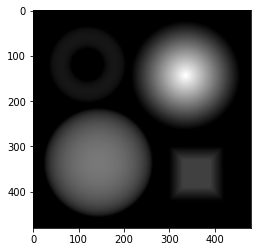

In [16]:
depth_map_image: np.ndarray = estimate_depth_map(
    NORMAL_MAP_PATH,
    normal_map_is_open_gl=NORMAL_MAP_IS_OPEN_GL,
    target_iteration_count=TARGET_ITERATION_COUNT,
    max_thread_count=MAX_THREAD_COUNT,
)

cv.imwrite(DEPTH_MAP_PATH, depth_map_image)
plt.imshow(depth_map_image, cmap="gray")
